In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from IPython.display import display

from nlp_adversarial_attacks.utils.file_io import load_json
from nlp_adversarial_attacks.utils.notebook import (
    CMAP,
    columns_order_to_sort,
    display_tables,
    extract_infos,
    plot_confusion_matrix_serie,
    remove_columns,
    scatter_plot,
    select_experiment,
)

pd.set_option("display.max_columns", None)

In [2]:
all_experiments_dir = Path("data_tcab/detection-experiments/")

df_list = []
for metrics_path in all_experiments_dir.glob("**/metrics.json"):
    # print(metrics_path)
    infos = extract_infos(metrics_path)
    metrics = load_json(metrics_path)
    infos.update(metrics)
    df_list.append(infos)

df = pd.DataFrame(df_list)

In [3]:
for column in df.columns:
    if "confusion_matrix" in column:
        df[column] = df[column].apply(lambda x: np.array(x))

df = df[df.setting == "multiclass_with_clean"]
df = remove_columns(df, ["train", "test", "recall", "precision", "f1_score", "roc_auc"])

In [4]:
df.sample(3)

,target_dataset,target_model,embeddings,setting,classification_model,feature_setting,is_binary,validation_accuracy,validation_balanced_accuracy,validation_confusion_matrix,best_params,classes_labels,important_features,feature_names,coef,intercept
45,allocine,distilcamembert,fr+small,multiclass_with_clean,RF,bert,False,0.429420,0.392081,"[[38, 70, 11, 43, 38, 19, 9], [27, 267, 12, 30...","{'randomforestclassifier__max_depth': 5, 'rand...","[bae, clean, deepwordbug, input_reduction, pww...",None,"[lm_bert_0, lm_bert_1, lm_bert_2, lm_bert_3, l...",None,None
19,allocine,distilcamembert,default,multiclass_with_clean,LR,bert+tp+lm,False,0.617634,0.599348,"[[87, 57, 11, 16, 15, 18, 24], [58, 221, 24, 1...",{'logisticregression__C': 0.1},"[bae, clean, deepwordbug, input_reduction, pww...",None,"[lm_perplexity_region0, lm_perplexity_region1,...",{'bae': {'lm_perplexity_region0': 0.0741510695...,None
46,allocine,distilcamembert,fr+small,multiclass_with_clean,RF,bert+tp,False,0.521243,0.484753,"[[49, 54, 16, 39, 26, 33, 11], [15, 247, 25, 2...","{'randomforestclassifier__max_depth': 5, 'rand...","[bae, clean, deepwordbug, input_reduction, pww...",None,"[avg_word_length_mean_region0, avg_word_length...",None,None


In [5]:
df.columns

Index(['target_dataset', 'target_model', 'embeddings', 'setting',
       'classification_model', 'feature_setting', 'is_binary',
       'validation_accuracy', 'validation_balanced_accuracy',
       'validation_confusion_matrix', 'best_params', 'classes_labels',
       'important_features', 'feature_names', 'coef', 'intercept'],
      dtype='object')

In [6]:
COLUMNS_ORDER = {
    "embeddings": ["default", "fr+small"],
    "feature_setting": ["bert", "bert+tp", "bert+tp+lm", "all"],
    "classification_model": ["LR", "RF", "LGB"],
}
COLUMNS_KEY = columns_order_to_sort(COLUMNS_ORDER)

## Table

In [7]:
display_tables(
    df, COLUMNS_ORDER, COLUMNS_KEY, transpose=False, sort_metric="validation_accuracy"
)

,validation_accuracy,validation_balanced_accuracy
embeddings,,
fr+small,0.618281,0.585801
default,0.544769,0.525839


,validation_accuracy,validation_balanced_accuracy
feature_setting,,
all,0.691868,0.661033
bert+tp+lm,0.599132,0.569178
bert+tp,0.562433,0.541809
bert,0.472666,0.451260


,validation_accuracy,validation_balanced_accuracy
classification_model,,
LR,0.652124,0.628280
LGB,0.598390,0.569164
RF,0.494061,0.470017


In [8]:
display_tables(df, COLUMNS_ORDER, COLUMNS_KEY, transpose=True)

embeddings,default,fr+small
feature,,
validation_accuracy,0.544769,0.618281
validation_balanced_accuracy,0.525839,0.585801


feature_setting,bert,bert+tp,bert+tp+lm,all
feature,,,,
validation_accuracy,0.472666,0.562433,0.599132,0.691868
validation_balanced_accuracy,0.451260,0.541809,0.569178,0.661033


classification_model,LR,RF,LGB
feature,,,
validation_accuracy,0.652124,0.494061,0.598390
validation_balanced_accuracy,0.628280,0.470017,0.569164


In [9]:
df_temp = (
    df.groupby(["embeddings", "feature_setting"])
    .mean(numeric_only=True)
    .drop(columns=["is_binary"])
)
df_temp = df_temp.sort_values("validation_accuracy", ascending=False).reset_index()

df_temp_style = df_temp.style.background_gradient(cmap=CMAP)
display(df_temp_style)

,embeddings,feature_setting,validation_accuracy,validation_balanced_accuracy
0,default,all,0.697122,0.666991
1,fr+small,all,0.686615,0.655076
2,fr+small,bert+tp+lm,0.631948,0.597374
3,fr+small,bert+tp,0.606517,0.575881
4,default,bert+tp+lm,0.566316,0.540983
5,fr+small,bert,0.548043,0.514873
6,default,bert+tp,0.518349,0.507736
7,default,bert,0.397289,0.387647


## Scatter plot

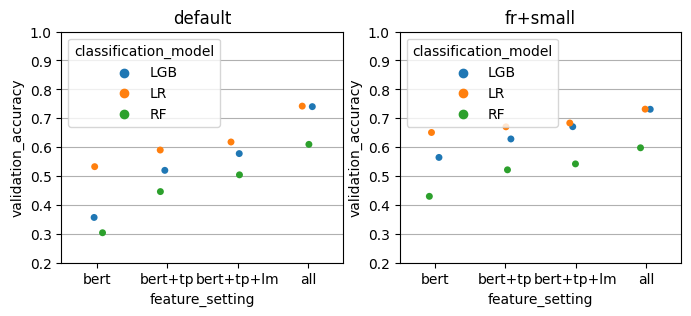

In [10]:
scatter_plot(
    df,
    COLUMNS_ORDER,
    ax_column="embeddings",
    x_column="feature_setting",
    color_column="classification_model",
    metric="validation_accuracy",
    ymin=0.2,
)

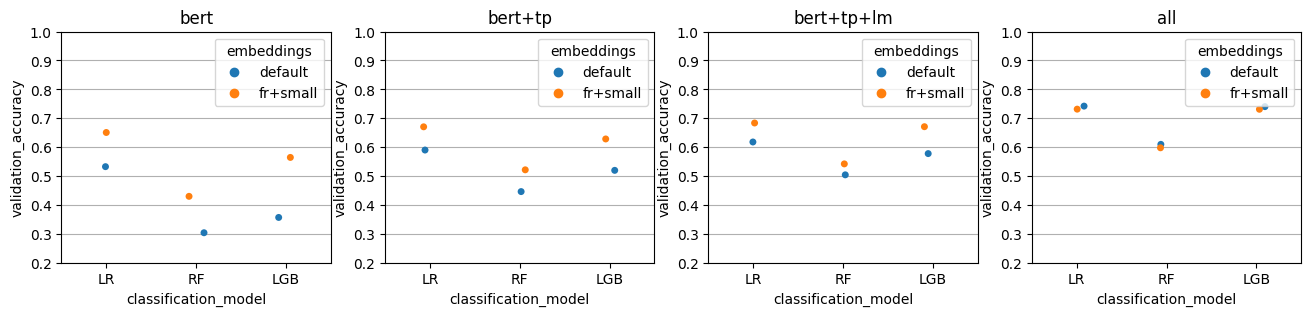

In [11]:
scatter_plot(
    df,
    COLUMNS_ORDER,
    ax_column="feature_setting",
    x_column="classification_model",
    color_column="embeddings",
    metric="validation_accuracy",
    ymin=0.2,
)

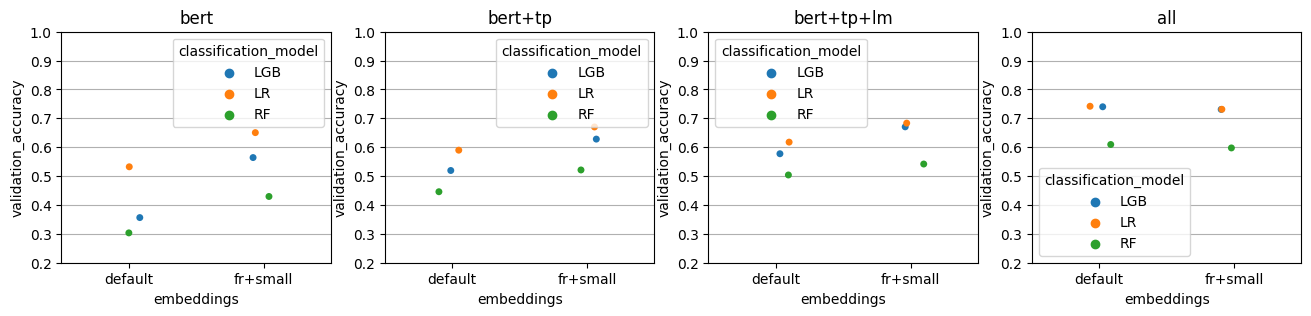

In [12]:
scatter_plot(
    df,
    COLUMNS_ORDER,
    ax_column="feature_setting",
    x_column="embeddings",
    color_column="classification_model",
    metric="validation_accuracy",
    ymin=0.2,
)

## Confusion matrix

In [13]:
df["classes_labels"] = df["classes_labels"].apply(lambda x: tuple(x))
assert (df.groupby("is_binary")["classes_labels"].nunique() == 1).all()

In [14]:
MULTI_CLASSES = df[~df["is_binary"]].iloc[0]["classes_labels"]

In [15]:
groupby_column = "feature_setting"
cm_serie = (
    df[df.setting == "multiclass_with_clean"]
    .groupby(groupby_column)["validation_confusion_matrix"]
    .mean()
    .sort_index(key=COLUMNS_KEY[groupby_column])
)
cm_serie

feature_setting
bert          [[70.66666666666667, 47.833333333333336, 11.83...
bert+tp       [[84.33333333333333, 36.833333333333336, 16.83...
bert+tp+lm    [[89.33333333333333, 59.5, 10.0, 23.6666666666...
all           [[139.66666666666666, 7.833333333333333, 8.0, ...
Name: validation_confusion_matrix, dtype: object

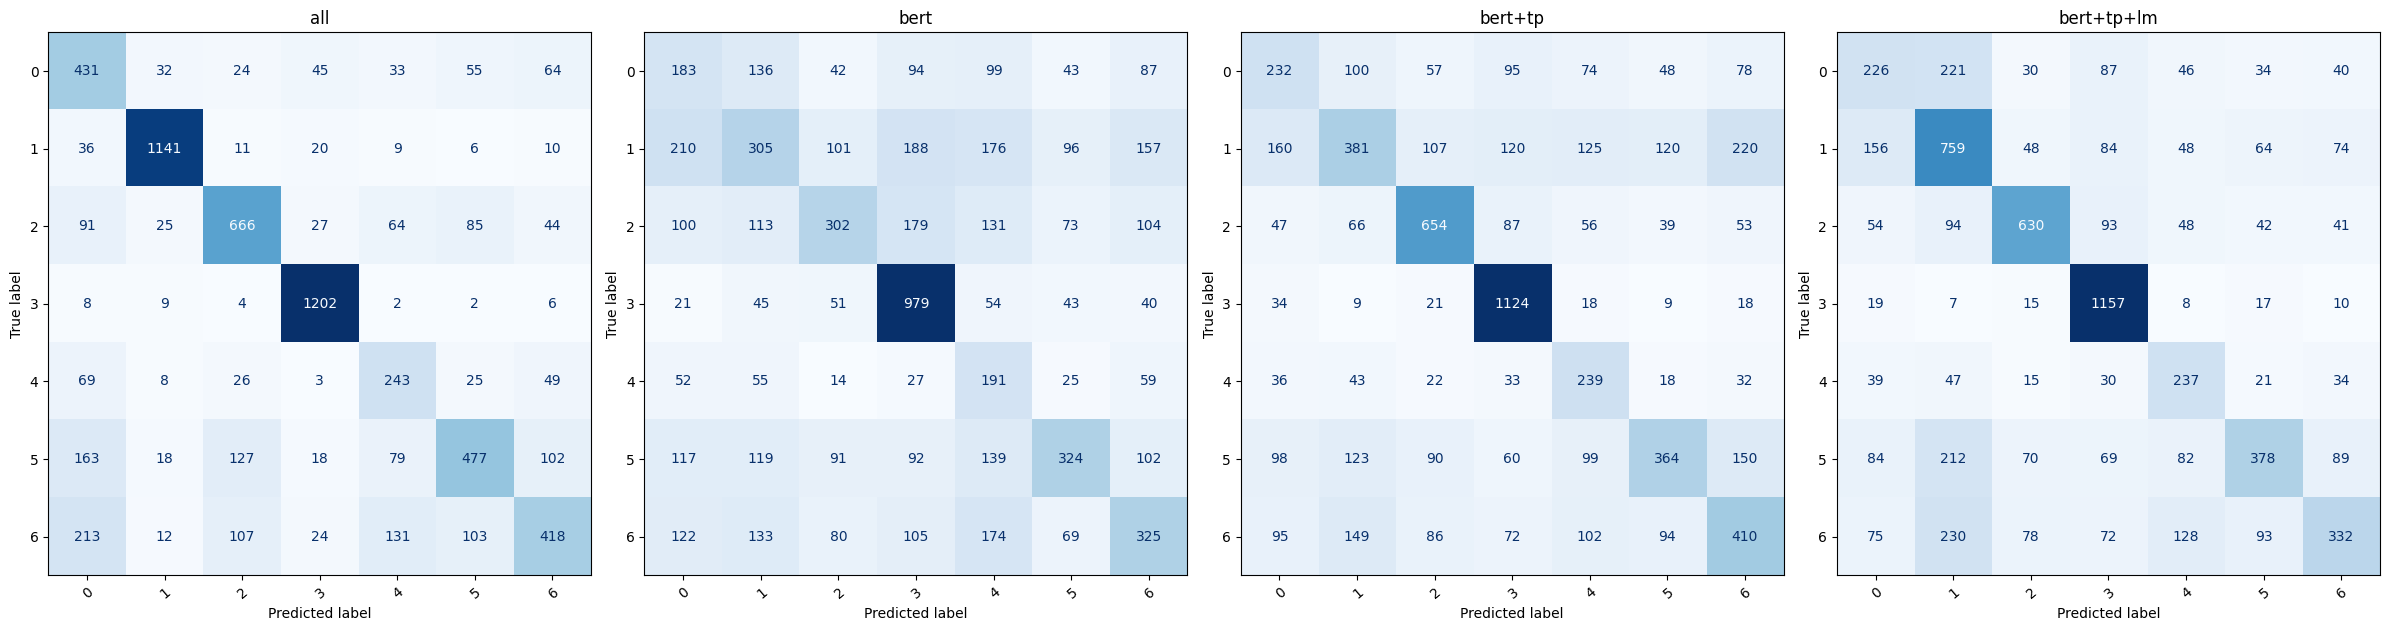

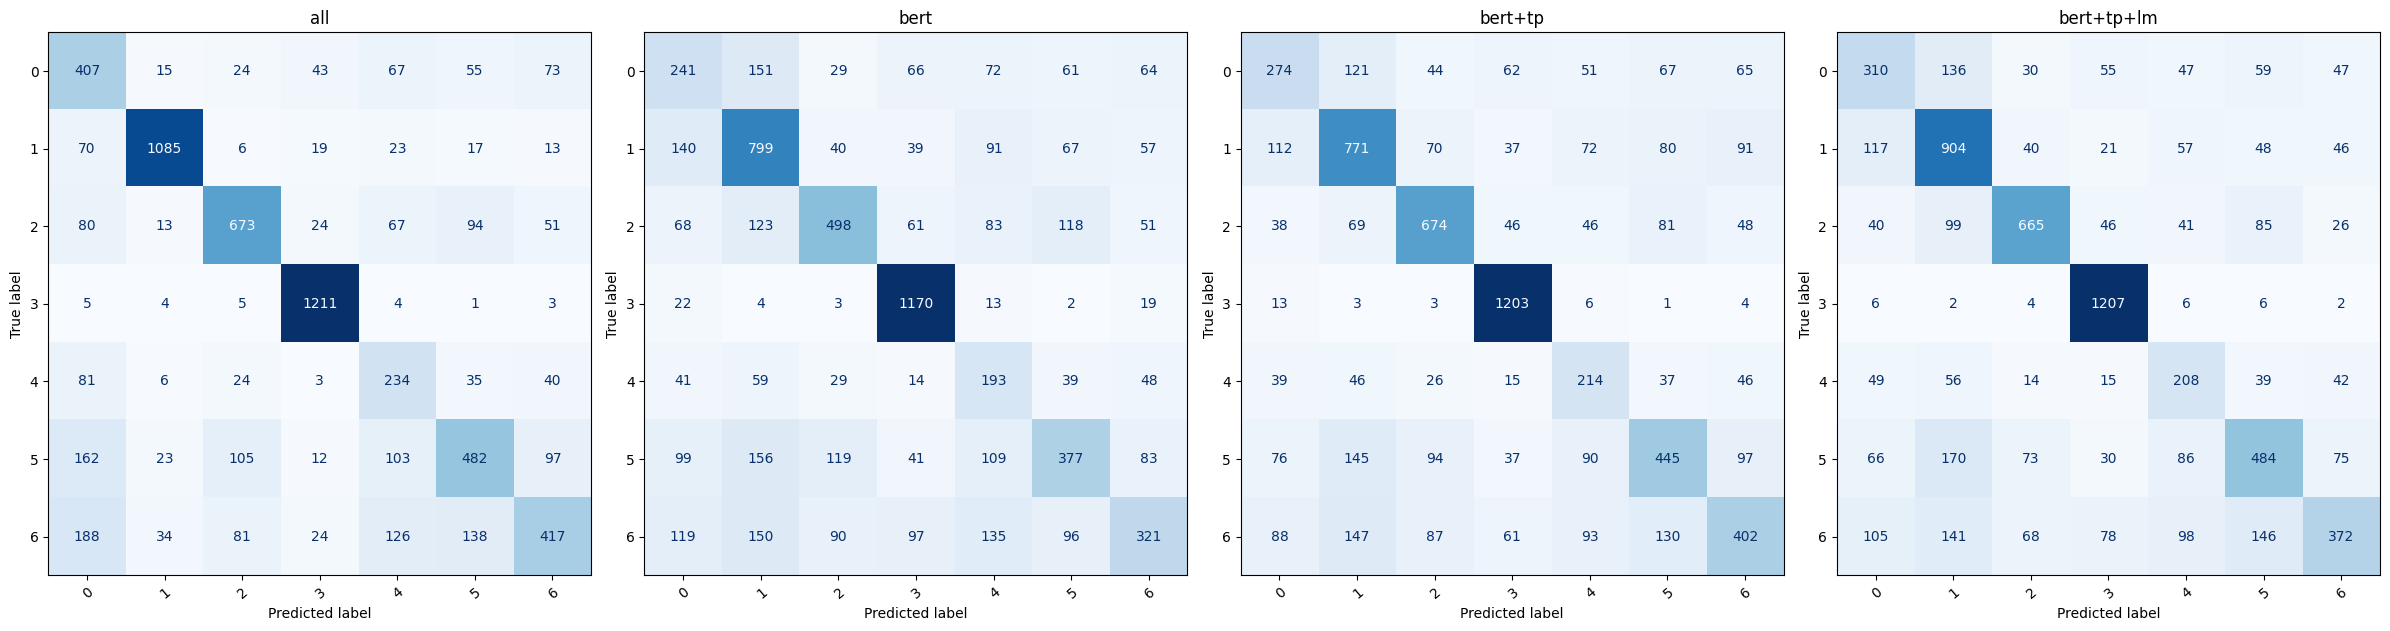

In [16]:
column1 = "embeddings"
column_groupby = "feature_setting"

for modality1 in COLUMNS_ORDER[column1]:
    cm_serie = (
        select_experiment(df, COLUMNS_ORDER, **{column1: modality1}, verbose=True)
        .groupby(column_groupby)["validation_confusion_matrix"]
        .sum()
    )
    plot_confusion_matrix_serie(cm_serie, binary_classes=MULTI_CLASSES)

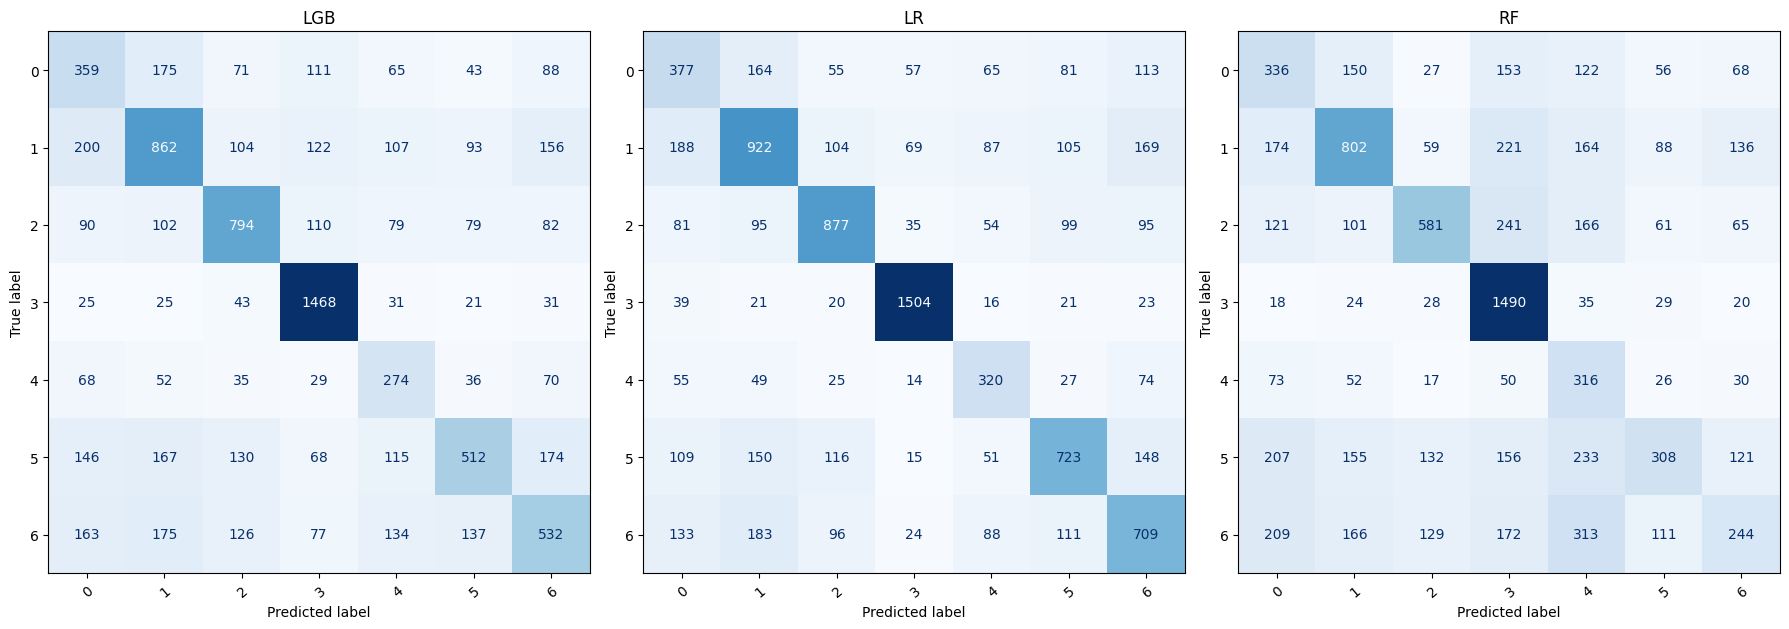

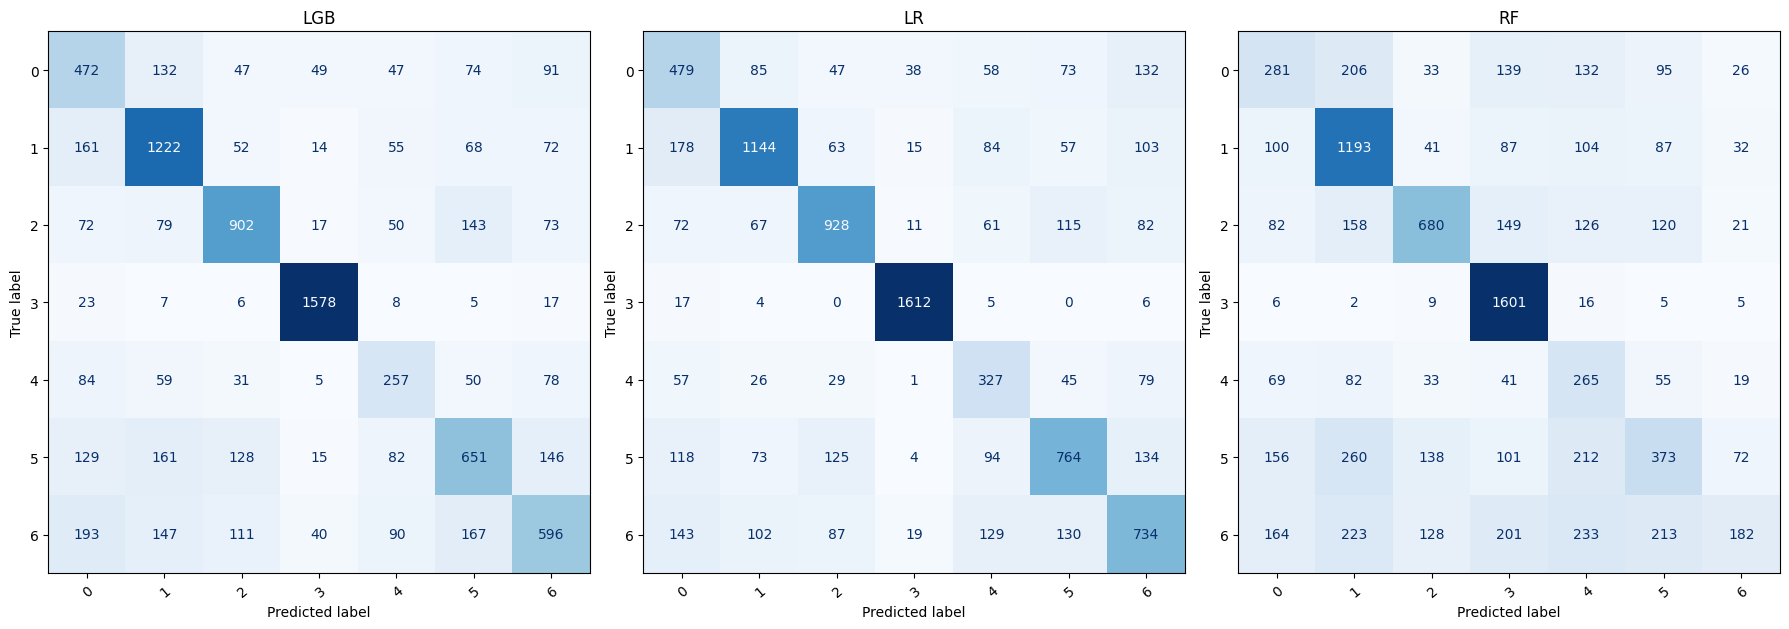

In [17]:
column1 = "embeddings"
column_groupby = "classification_model"

for modality1 in COLUMNS_ORDER[column1]:
    cm_serie = (
        select_experiment(df, COLUMNS_ORDER, **{column1: modality1}, verbose=True)
        .groupby(column_groupby)["validation_confusion_matrix"]
        .sum()
    )
    plot_confusion_matrix_serie(cm_serie, binary_classes=MULTI_CLASSES)

## Logistic regression coef

In [18]:
exp = select_experiment(
    df,
    COLUMNS_ORDER,
    embeddings="default",
    setting="multiclass_with_clean",
    classification_model="LR",
    feature_setting="all",
)

In [19]:
df_coef = pd.DataFrame(exp.coef)
for column in df_coef.columns:
    df_coef[column + "_abs"] = df_coef[column].abs()
df_coef.sort_values("clean_abs", ascending=False).head(25)

,bae,clean,deepwordbug,input_reduction,pwws,textbugger,textfooler,bae_abs,clean_abs,deepwordbug_abs,input_reduction_abs,pwws_abs,textbugger_abs,textfooler_abs
tm_gradient_mean_layer72_region3,-0.102941,0.256653,0.002336,0.026425,-0.051554,-0.035783,-0.095137,0.102941,0.256653,0.002336,0.026425,0.051554,0.035783,0.095137
tm_gradient_quant1_layer82_region3,-0.013247,-0.216177,0.061352,0.036080,-0.080630,-0.037644,0.250266,0.013247,0.216177,0.061352,0.036080,0.080630,0.037644,0.250266
tm_gradient_mean_layer104_region_3,-0.049701,0.212523,0.094009,0.056993,-0.250146,-0.080925,0.017247,0.049701,0.212523,0.094009,0.056993,0.250146,0.080925,0.017247
tm_activation_var_layer67_region3,-0.124394,0.200501,-0.064502,0.020816,0.093584,-0.138877,0.012873,0.124394,0.200501,0.064502,0.020816,0.093584,0.138877,0.012873
tm_activation_mean_layer31_region0,0.091146,-0.200274,0.086390,-0.055247,-0.001069,0.055412,0.023641,0.091146,0.200274,0.086390,0.055247,0.001069,0.055412,0.023641
tm_gradient_quant1_layer27_region3,-0.106603,-0.199348,0.005553,0.009546,0.130578,-0.005137,0.165410,0.106603,0.199348,0.005553,0.009546,0.130578,0.005137,0.165410
tm_activation_var_layer77_region3,-0.077174,0.185368,0.057331,0.115828,0.047972,-0.101041,-0.228285,0.077174,0.185368,0.057331,0.115828,0.047972,0.101041,0.228285
tm_gradient_quant1_layer42_region3,0.176241,0.184794,-0.114119,0.042680,-0.277801,0.054475,-0.066270,0.176241,0.184794,0.114119,0.042680,0.277801,0.054475,0.066270
tm_gradient_quant1_layer28_region3,0.025092,0.183879,-0.051440,-0.055002,0.026291,-0.106197,-0.022623,0.025092,0.183879,0.051440,0.055002,0.026291,0.106197,0.022623
avg_word_length_var_region0,-0.050666,0.182373,-0.073392,-0.112304,0.095537,-0.013025,-0.028523,0.050666,0.182373,0.073392,0.112304,0.095537,0.013025,0.028523
